In [1]:
import numpy as np
import wormholes as wh
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.tri import Triangulation
from scipy.optimize import curve_fit
from tqdm import tqdm
import colorcet as cc

In [2]:
# Suppress warnings
# (Many overflows/underflows otherwise, since exp(u,v,φ) appear throughout)
import warnings
warnings.filterwarnings('ignore')

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
plt.rcParams['figure.dpi'] = 150
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = '\\usepackage{amssymb} \\usepackage{amsmath}'

# Massive type IIA on $S^3\times S^3$

A consistent truncation of massive type IIA SUGRA on $S^3\times S^3$ is described by the following 4D action:

$$ \begin{align*}
    S_4 &= \frac{1}{2\kappa_4^2}\int\Big( {\star R} - \frac{1}{2}\mathrm{d}\phi\wedge{\star\mathrm{d}\phi} - 6\,\mathrm{d}u\wedge{\star\mathrm{d}u} + \frac{1}{2}e^{-3u+\phi/2}\mathrm{d}\chi\wedge{\star\mathrm{d}\chi} - {\star\mathcal{V}} \Big) \,,\\
    \mathcal{V} &= -12e^{-4u} + 5e^{-9u-\phi/2} + e^{-3u+5\phi/2} \,.
\end{align*} $$

By design, the minimum of $\mathcal{V}$ is at $u=\phi=0$. The $\chi$ equation of motion can be solved in terms of the axion charge $\mathfrak{q}$ as $e^{-3u+\phi/2}\mathrm{d}\chi = \mathfrak{q}\,\mathrm{d}h$, where $h$ is harmonic. The remaining equations of motion must be solved numerically, and we pick the following metric ansatz,

$$ \mathrm{d}s_4^2 = f^2\,\mathrm{d}r^2 + q^2\,\mathrm{d}\Omega_3^2 \,, \qquad q^2 = q_0^2 + r^2 \,, $$

which facilitates finding wormhole solutions: $q_0$ is the wormhole size and the coordinate $r$ covers the full geometry. All of $f,u,\phi$ are taken to be (even) functions of $r$ only.

Regular wormholes are found using a shooting method: $q_0$ is fixed and values for $u$ and $\phi$ are chosen at the wormhole throat ($r=0$) in such a way that the AdS boundary conditions are met for $r\to\infty$.

### Example profiles & shooting method

Picking $(u_0,\phi_0)$ by hand typically results in singular solutions.

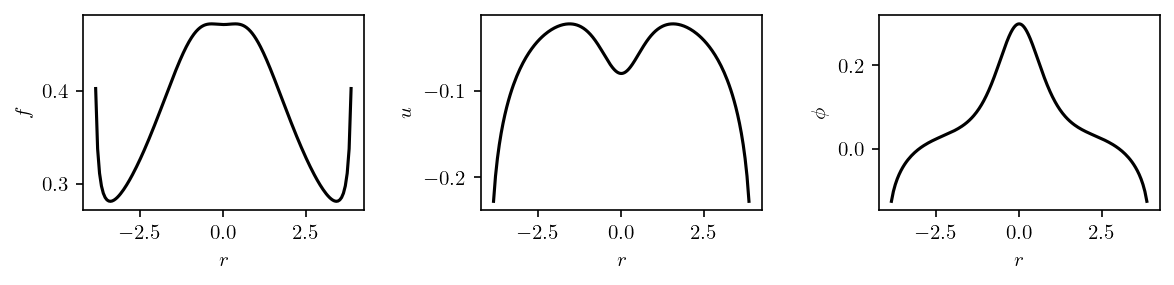

In [5]:
q0, rmax = 1, 5
u0, φ0 = -0.08, 0.3

soln = wh.solve_S3S3(q0, u0, φ0, rmax)
r, f, u, ud, φ, φd, h, charge = wh.symmetrize_S3S3(soln)

fig, axes = plt.subplots(1, 3, figsize=(8,2))

for ax, y, label in zip(axes, [f, u, φ], ['$f$', '$u$', '$\phi$']):
    ax.plot(r, y, 'k')
    ax.set_xlabel('$r$')
    ax.set_ylabel(label)

plt.tight_layout()
plt.show()

Optimal values for $(u_0,\phi_0)$ to match the AdS boundary conditions ($f\sim\frac{1}{r}$ and $u,\phi\to0$ for $r\to\infty$) are found using a shooting method.

S3xS3: (q0, rmax) = (1.000000, 20.000000)...
       success : True
        f_eval : 158
            u0 : -0.0789187231
            v0 : +0.2943216215
         value : 0


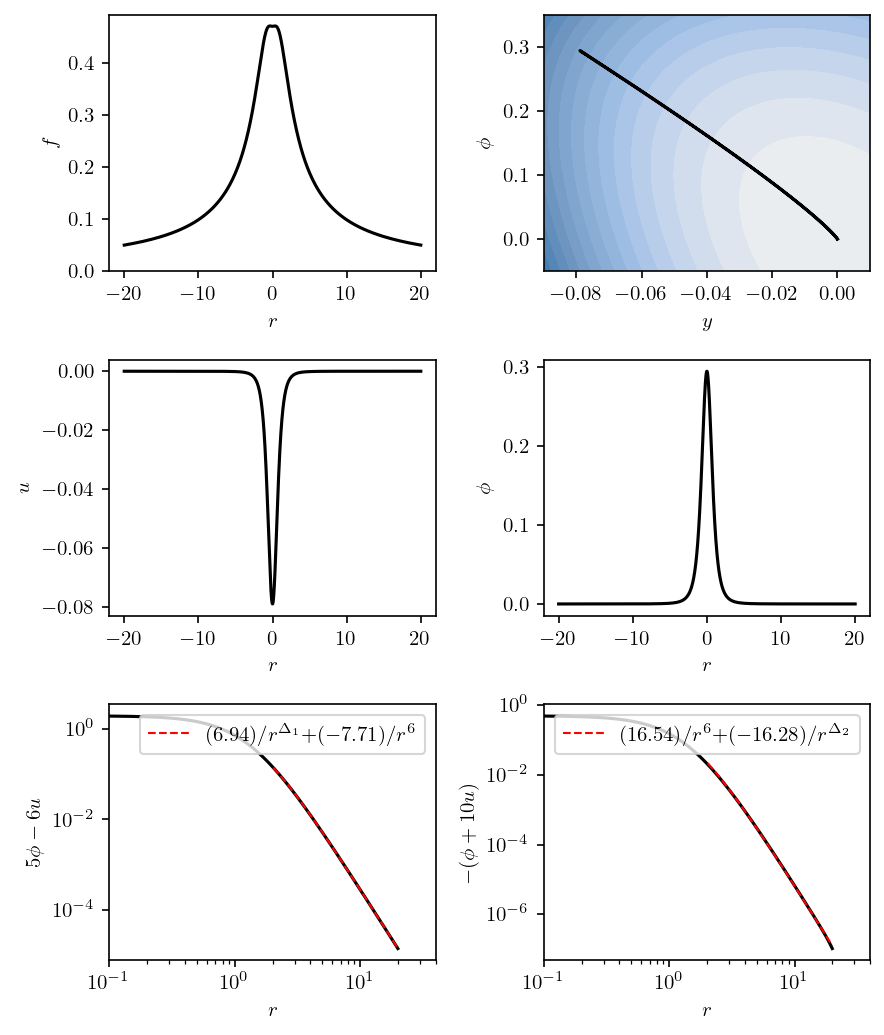

In [7]:
q0, rmax = 1, 20

soln = wh.wormhole_S3S3(q0, rmax, display_summary=True)
r, f, u, ud, φ, φd, h, charge = soln



fig, axes = plt.subplots(3, 2, figsize=(6,7))

q = wh.Q(r, q0)

xdata = [r, u, r, r, r, r]
ydata = [f, φ, u, φ, 5*φ-6*u, -(φ+10*u)]
xlabels = ['$r$', '$y$', '$r$', '$r$', '$r$', '$r$']
ylabels = ['$f$', '$\phi$', '$u$', '$\phi$', '$5\phi-6u$', '$-(\phi+10u)$']

# Plot grid of xy-data
for ax, xx, yy, xlab, ylab in zip(axes.ravel(), xdata, ydata, xlabels, ylabels):
    ax.plot(xx, yy, 'k')
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)

axes[0,0].set_ylim(0)

# Superimpose potential in u-φ plot
u0s = np.linspace(-0.09, 0.01, 40)
φ0s = np.linspace(-0.05, 0.35, 40)
umesh, φmesh = np.meshgrid(u0s, φ0s)
VV = wh.V_S3S3(umesh, φmesh)

axes[0,1].contourf(umesh, φmesh, VV,
                   levels=np.arange(-6, -4.4, 0.1),
                   cmap=cc.cm['CET_L12'],
                   extent=(u0s[0], u0s[-1], φ0s[0], φ0s[-1])
                  )

axes[0,1].set_xlim(u0s[0], u0s[-1])
axes[0,1].set_ylim(φ0s[0], φ0s[-1])


# Plot expected power-law fall-offs in asymptotic region
rr, light, label_light = wh.fitLightMode_S3S3(q0, r, u, φ, r>2)
axes[2,0].plot(rr, light, '--r', lw=1, label=label_light)

rr, heavy, label_heavy = wh.fitHeavyMode_S3S3(q0, r, u, φ, r>2)
axes[2,1].plot(rr, heavy, '--r', lw=1, label=label_heavy)


for ax in axes[2]:
    ax.set_xlim(0.1*q0, 2*rmax)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.legend()

plt.tight_layout()
# plt.savefig('images/S3S3_profile_example.png', dpi=300)
plt.show()

### Scalar field ranges

Field ranges for $u$ and $\phi$ remain $\mathcal{O}(1)$ for all $q_0$. Below the field ranges are compared to the ranges of the Giddings-Strominger solution which appears when $u$ and $\phi$ are "approximated" to be massless (via the _ad hoc_ replacement $\mathcal{V}\to -6$).

In [8]:
q0s = np.geomspace(0.0001, 100, 50)

q0s_ml = np.geomspace(min(q0s), max(q0s), 100)
data_ml = np.asarray([wh.massless_approx_S3S3(q0) for q0 in q0s_ml])
u0s_ml, φ0s_ml, charges_ml = data_ml.T

data = []

for q0 in tqdm(q0s):

    rmax = max(10, 10*q0)
    soln = wh.wormhole_S3S3(q0, rmax)
    r, f, u, ud, φ, φd, h, charge = soln

    # It happens that u<0 and φ>0
    data.append([min(u), max(φ), charge])

u0s, φ0s, charges = np.asarray(data).T

100%|██████████| 50/50 [11:36<00:00, 13.94s/it]


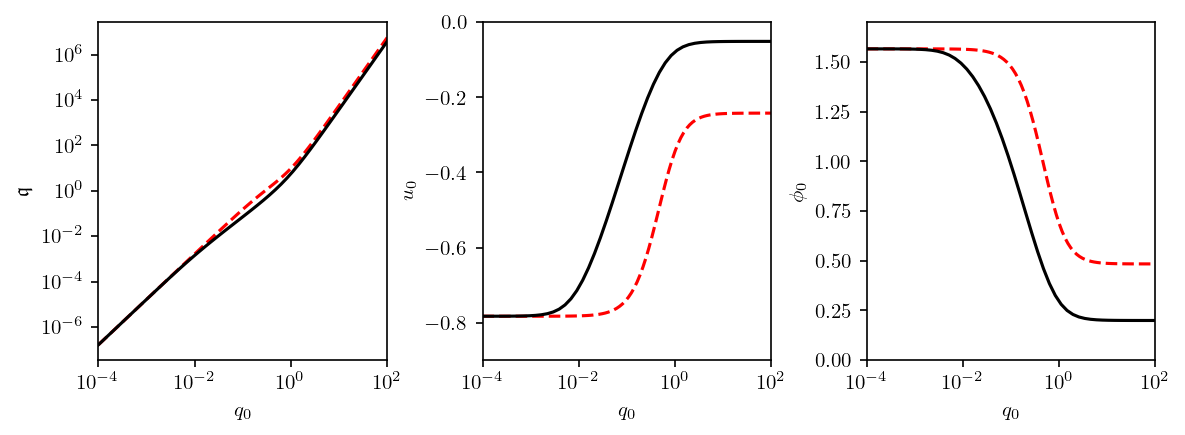

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(8,3), sharex=True)

axes[0].plot(q0s_ml, charges_ml, '--r')
axes[0].plot(q0s, charges, 'k')
axes[0].set_yscale('log')
axes[0].set_ylabel('$\mathfrak{q}$')

axes[1].plot(q0s_ml, u0s_ml, '--r')
axes[1].plot(q0s, u0s, 'k')
axes[1].set_ylabel('$u_0$')
axes[1].set_ylim(-0.9, 0)

axes[2].plot(q0s_ml, φ0s_ml, '--r')
axes[2].plot(q0s, φ0s, 'k')
axes[2].set_ylabel('$\phi_0$')
axes[2].set_ylim(0, 1.7)

plt.xlim(min(q0s), max(q0s))
plt.xscale('log')
for ax in axes:
    ax.set_xlabel('$q_0$')

plt.tight_layout()
plt.subplots_adjust(wspace=0.33)
# plt.savefig('images/S3S3_ranges.png', dpi=300)
plt.show()

### Flat-space limit

The flat-space limit is $\ell\to\infty$ with $a_0=\ell q_0$ held fixed. As $q_0\ll1$ there are three distinct regions: (i) $r\lesssim q_0$ is within the wormhole where $u,\phi,f$ are approximately constant, (ii) $q_0\lesssim r\lesssim 1$ is 'outside' the wormhole but still below the AdS scale where $u,\phi$ decay as $1/r^2$ (like massless scalars in flat space) and $f\approx 1$, and (iii) $r\gtrsim 1$ is above the AdS scale where the light/heavy eigenstates decay towards the boundary. The appropriately rescaled radial coordinate and flux to realize the flat-space limit are $\ell r$ and $\ell^2\mathfrak{f}$. Notice that the metric only converges point-wise (i.e. not uniformly) since $f\to1$ in the flat-space limit $\ell\to\infty$, while $f\xrightarrow{\ell r\gtrsim\ell}\frac{1}{r}$ for any finite $\ell$.

100%|██████████| 5/5 [01:39<00:00, 19.89s/it]


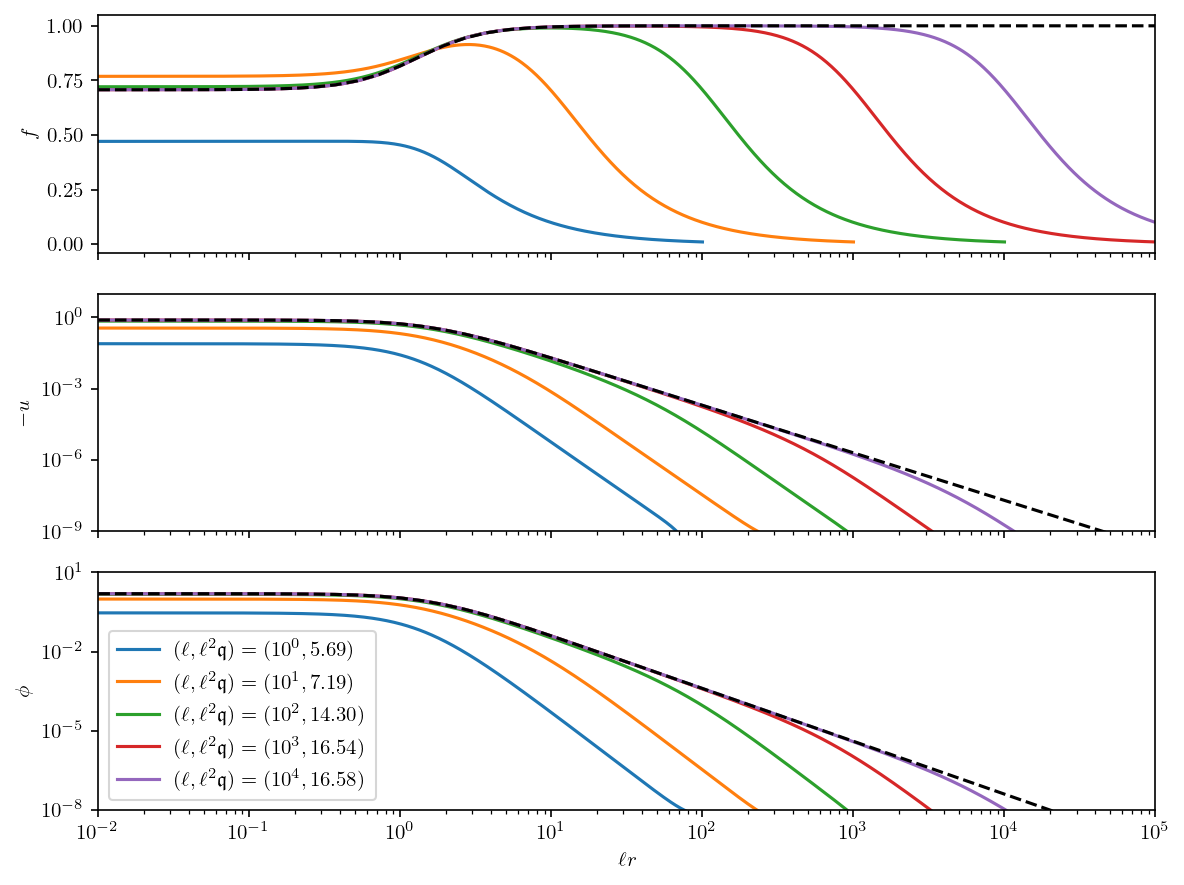

In [17]:
a0 = 1
powers = np.arange(0, 5, 1)

fig, axes = plt.subplots(3, 1, figsize=(8,6), sharex=True)

for power in tqdm(powers):
    l = 10**power
    q0 = a0 / l
    
    rmax = min(100, 10**5 / l)
    soln = wh.wormhole_S3S3(q0, rmax)
    r, f, u, ud, φ, φd, h, charge = soln

    axes[0].plot(l*r, f)

    cut = np.where((r > 0) * (-u < 10**-9))[0][0]
    axes[1].plot(l*r[:cut], -u[:cut])

    axes[2].plot(l*r, φ, label='$(\ell,\ell^2\mathfrak q)=(10^{},{:.2f})$'.format(power, charge*l**2))


# Plot flat-space profiles
rr = np.geomspace(10**-2, 10**5)
a = wh.Q(rr, a0)
ad = wh.Qd(rr, a0)

ff = ad / np.sqrt(1 - (a0/a)**4)
φφ = np.log(np.cos(np.sqrt(3)/2 * np.arctan(np.sqrt((a/a0)**4 - 1))) / np.cos(np.sqrt(3)*np.pi/4))

axes[0].plot(rr, ff, '--k')
axes[1].plot(rr, 0.5*φφ, '--k')
axes[2].plot(rr, φφ, '--k')


plt.xlim(10**-2, 10**5)
plt.xscale('log')
plt.xlabel('$\ell r$')

axes[0].set_ylabel('$f$')

axes[1].set_ylim(10**-9, 10)
axes[1].set_yscale('log')
axes[1].set_ylabel('$-u$')

axes[2].set_ylim(10**-8, 10)
axes[2].set_yscale('log')
axes[2].set_ylabel('$\phi$')
axes[2].legend()

plt.tight_layout()
# plt.savefig('images/S3S3_flat_limit.png', dpi=300)
plt.show()

# Type IIB on $T^{1,1}$

A consistent truncation of type IIB SUGRA on $T^{1,1}$ is described by the following 5D action:

$$ \begin{align*}
    S_5 &= \frac{1}{2\kappa_5^2}\int\Big( {\star R} - \frac{1}{2}\mathrm{d}\phi\wedge{\star\mathrm{d}\phi} + \frac{1}{2}e^{2\phi}\mathrm{d}\chi\wedge{\star\mathrm{d}\chi}\\
    &\qquad\qquad - \frac{1}{2}e^{-4u-\phi}\mathrm{d}b\wedge{\star\mathrm{d}b} + \frac{1}{2}e^{-4u+\phi}(\mathrm{d}c - \chi\,\mathrm{d}b)\wedge{\star(\mathrm{d}c - \chi\,\mathrm{d}b)}\\
    &\qquad\qquad - \frac{28}{3}\mathrm{d}u\wedge{\star\mathrm{d}u} - \frac{8}{3}\mathrm{d}u\wedge{\star\mathrm{d}v} - \frac{4}{3}\mathrm{d}v\wedge{\star\mathrm{d}v} - {\star\mathcal{V}} \Big) \,,\\
    \mathcal{V} &= 2e^{-\frac{8}{3}(4u+v)}\big(2e^{4u+4v} - 12e^{6u+2v} + 4\big) \,.
\end{align*} $$

By design, the minimum of $\mathcal{V}$ is at $u=v=0$. The $b$ and $c$ equations of motion can be solved in terms of axion charges $\mathfrak{q}_1,\mathfrak{q}_2$. The remaining equations of motion must be solved numerically, and we pick the following metric ansatz,

$$ \mathrm{d}s_5^2 = f^2\,\mathrm{d}r^2 + q^2\,\mathrm{d}\Omega_4^2 \,, \qquad q^2 = q_0^2 + r^2 \,, $$

which facilitates finding wormhole solutions: $q_0$ is the wormhole size and the coordinate $r$ covers the full geometry. All of $f,u,v,\phi$ are taken to be even functions of $r$ while $\chi$ is taken to be odd.

Regular wormholes are found using a shooting method: $q_0$ and $(e^\phi\chi')_0$ are fixed and values for $u$ and $v$ are chosen at the wormhole throat ($r=0$) in such a way that the AdS boundary conditions are met for $r\to\infty$ (one can always use an $\mathrm{SL}(2,\mathbb{R})$ transformation to set $\phi(\infty)=0$, so wlg $\phi(0)=0$ for the numerics).

### Example profiles & shooting method

Picking $(u_0,v_0)$ by hand typically results in singular solutions.

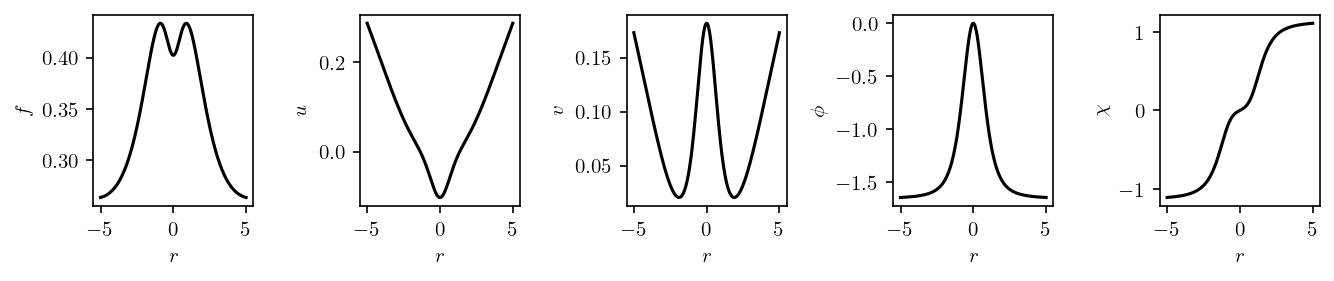

In [18]:
q0, rmax = 1, 5
u0, v0 = -0.102, 0.182
χ1 = 0.1

soln = wh.solve_T11(q0, u0, v0, 0, χ1, rmax)
r, f, u, ud, v, vd, φ, φd, χ, χd, h, charge2 = wh.symmetrize_T11(soln)

fig, axes = plt.subplots(1, 5, figsize=(9,2))

for ax, y, label in zip(axes, [f, u, v, φ, χ], ['$f$', '$u$', '$v$', '$\phi$', '$\chi$']):
    ax.plot(r, y, 'k')
    ax.set_xlabel('$r$')
    ax.set_ylabel(label)

plt.tight_layout()
plt.show()

Optimal values for $(u_0,v_0)$ to match the AdS boundary conditions ($f\sim\frac{1}{r}$ and $u,v,\phi',\chi'\to0$ for $r\to\infty$) are found using a shooting method.

T11: (q0, χ1, rmax) = (1.000000, 0.100000, 10.000000)...
       success : True
        f_eval : 249
            u0 : -0.1028891470
            v0 : +0.1823857261
         value : 0


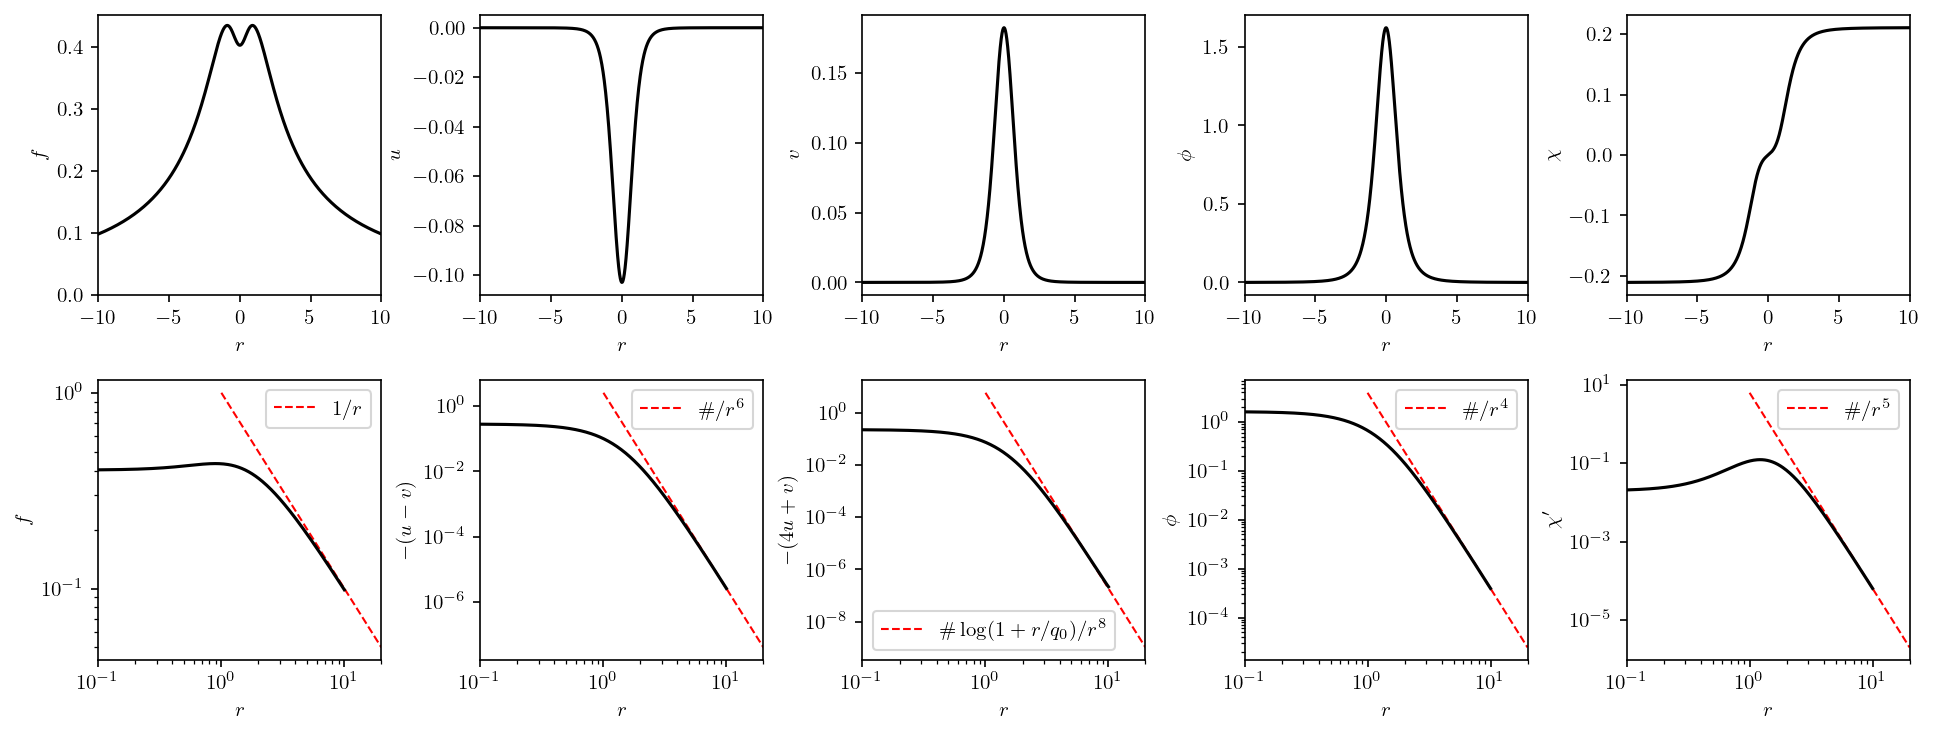

In [61]:
q0 = 1
rmax = 10
χ1 = 0.1

soln, val_final = wh.wormhole_T11(q0, χ1, rmax, display_summary=True)
r, f, u, ud, v, vd, φ, φd, χ, χd, h, charge2 = soln


fig, axes = plt.subplots(2, 5, figsize=(13, 5), sharex='row')

ydata = [f, u, v, φ, χ, f, -(u-v), -(4*u+v), φ, χd]
ylabels = ['$f$', '$u$', '$v$', '$\phi$', '$\chi$', '$f$', '$-(u-v)$', '$-(4u+v)$', '$\phi$', '$\chi\'$']


# Plot expected power-law fall-offs in asymptotic region
uvcoeff1 = np.mean(r[-10:]**6 * (-u[-10:] + v[-10:]))
uvcoeff2 = np.mean(r[-10:]**8 * (-4*u[-10:] - v[-10:]) / np.log(1 + r[-10:]/q0))
φ4 = np.mean(r[-10:]**4 * φ[-10:])
χ4 = np.mean(-0.25 * r[-10:]**5 * χd[-10:])


rr = np.linspace(q0, 2*rmax, 2)
axes[1,0].plot(rr, 1/rr, '--r', lw=1, label='$1/r$')
axes[1,1].plot(rr, uvcoeff1/rr**6, '--r', lw=1, label='$\#/r^6$')
axes[1,2].plot(rr, uvcoeff2 * np.log(1+rr/q0)/rr**8, '--r', lw=1, label='$\#\log(1+r/q_0)/r^8$')
axes[1,3].plot(rr, φ4/rr**4, '--r', lw=1, label='$\#/r^4$')
axes[1,4].plot(rr, -4*χ4/rr**5, '--r', lw=1, label='$\#/r^5$')

# Plot grid of xy-data
for ax, yy, ylab in zip(axes.ravel(), ydata, ylabels):
    ax.plot(r, yy, 'k')
    ax.set_xlabel('$r$')
    ax.set_ylabel(ylab)

axes[0,0].set_ylim(0)

for ax in axes[1]:
    ax.set_yscale('log')
    ax.legend()


axes[0,0].set_xlim(-rmax, rmax)
axes[1,0].set_xlim(0.1*q0, 2*rmax)
axes[1,0].set_xscale('log')

plt.tight_layout()
plt.subplots_adjust(wspace=0.35)
# plt.savefig('images/T11_profiles_ex1.png', dpi=300)
plt.show()

### Scalar field ranges & BPS bounds

First collect/load data:

In [19]:
# data_T11 = np.empty([13, 0])
data_T11 = np.load('T11_data.npy')

In [20]:
# Polynomial parameters which estimate the largest χ1 as a function of log(q0) on 0.01 < q0 < 10
# Evaluate using np.polyval(χ1max_fit_params, np.log(q0))
χ1max_fit_params = [ 8.36517999e-06,  1.11900249e-04,  3.82278703e-04, -8.83490112e-04,
                    -6.79118040e-03, -1.32155348e-03,  4.40613220e-02,  3.02091352e-02,
                    -1.61250423e-01, -1.50605858e-01,  5.43067718e-01]

In [21]:
def run(q0, χ1, rmax, xatol=10**-10, display_summary=False, display_progress=False):

    soln, value = wh.wormhole_T11(q0, χ1, rmax,
                                  xatol=xatol,
                                  display_summary=display_summary,
                                  display_progress=display_progress
                                 )

    if soln is None or value > 10**-4:
        return None, value
        
    r, f, u, ud, v, vd, φ, φd, χ, χd, h, charge2 = soln

    # Get field ranges
    u0 = min(u)
    v0 = max(v)
    φ0 = max(φ)

    # Get Ricci scalars (5D and 10D)
    ric5 = min(wh.ricci_5D(q0, soln))
    ric10 = min(wh.ricci_10D(q0, soln))

    # Estimate φ4, χ4 and χinf
    mask = (r > rmax/1.5)
    
    popt, pcov = curve_fit(wh.masslessScalarFit_alt, r[mask]/q0, r[mask]**5 * φd[mask])
    φ4 = popt[0]

    popt, pcov = curve_fit(wh.masslessScalarFit_alt, r[mask]/q0, r[mask]**5 * (φd[mask] + χd[mask]))
    φχ4 = popt[0]
    
    if χ1 == 0:
        χinf, χ4 = 0, 0
    else:
        popt, pcov = curve_fit(wh.masslessScalarFit, r[mask]/q0, χ[mask])
        χinf = popt[0]

        popt, pcov = curve_fit(wh.masslessScalarFit_alt, r[mask]/q0, r[mask]**5 * χd[mask])
        χ4 = popt[0]

    return [q0, χ1, rmax, u0, v0, φ0, φ4, χ4, φχ4, χinf, charge, ric5, ric10], value

In [89]:
# n_q0 = 50

# q0_list = 10**(3*np.random.rand(n_q0) - 2)
# q0_list = np.geomspace(0.01, 10, 10)
q0_list = [0.012]

for q0 in q0_list:

    # Data for fixed q0
    data_q0 = np.empty([13, 0])

    rmax = max(10, 10*q0)

    # Estimate χ1max for 0.01 < q0 < 10
    χ1max_est = np.polyval(χ1max_fit_params, np.log(q0))

    # Do scan over evenly spaced χ1
    χ1_list = χ1max_est * np.linspace(0, 1, 10, endpoint=False)
    # χ1_list = [(0.25*np.random.rand()+0.2)*χ1max_est]

    for χ1 in χ1_list:

        print('q0 = {:.4f}    χ1 = {:.8f}    χ1max_est = {:.8f}'.format(q0, χ1, χ1max_est), end='')
        run_data, value = run(q0, χ1, rmax, xatol=10**-16)

        if run_data is None:
            print('    Failed to converge')
        else:
            print('    χ1inf = {:.8f}    val_final = {:.4g}'.format(run_data[9], value))
            data_q0 = np.append(data_q0, np.array([run_data]).T, axis=1)


    # Now pick χ1 approaching χ1max geometrically
    for _ in range(20):

        # Get current estimate of χ1max by fitting the χ1(χ1inf) data and evaluating χ1(1)
        fit = np.polyfit(data_q0[9], data_q0[1], 3)
        χ1max_est = np.polyval(fit, 1)

        # Move part-way to χ1max_est
        χ1 = (2*χ1 + χ1max_est) / 3

        print('q0 = {:.4f}    χ1 = {:.8f}    χ1max_est = {:.8f}'.format(q0, χ1, χ1max_est), end='')
        run_data, value = run(q0, χ1, rmax)

        if run_data is None:
            print('    Failed to converge')
            break
        elif run_data[9] < data_q0[9, -1]:
            print('    Lower χ1inf')
            break
        else:
            print('    χ1inf = {:.8f}    val_final = {:.4g}'.format(run_data[9], value))
            data_q0 = np.append(data_q0, np.array([run_data]).T, axis=1)

    data_T11 = np.append(data_T11, data_q0, axis=1)

q0 = 0.0120    χ1 = 0.00000000    χ1max_est = 0.42039933    χ1inf = 0.00000000    val_final = 0
q0 = 0.0120    χ1 = 0.04203993    χ1max_est = 0.42039933    χ1inf = 0.09949695    val_final = 1.998e-15
q0 = 0.0120    χ1 = 0.08407987    χ1max_est = 0.42039933    χ1inf = 0.19899330    val_final = 4.441e-16
q0 = 0.0120    χ1 = 0.12611980    χ1max_est = 0.42039933    χ1inf = 0.29848850    val_final = 1.132e-14
q0 = 0.0120    χ1 = 0.16815973    χ1max_est = 0.42039933    χ1inf = 0.39798197    val_final = 4.441e-16
q0 = 0.0120    χ1 = 0.21019967    χ1max_est = 0.42039933    χ1inf = 0.49747315    val_final = 1.554e-15
q0 = 0.0120    χ1 = 0.25223960    χ1max_est = 0.42039933    χ1inf = 0.59696146    val_final = 9.77e-15
q0 = 0.0120    χ1 = 0.29427953    χ1max_est = 0.42039933    χ1inf = 0.69644633    val_final = 5.107e-15
q0 = 0.0120    χ1 = 0.33631946    χ1max_est = 0.42039933    χ1inf = 0.79592719    val_final = 8.882e-16
q0 = 0.0120    χ1 = 0.37835940    χ1max_est = 0.42039933    χ1inf = 0.895

In [22]:
data_T11 = data_T11[:, data_T11[9] < 1]
np.save('T11_data.npy', data_T11)

q0s, χ1s, rmaxs, u0s, v0s, φ0s, φ4s, χ4s, φχ4s, χinfs, charge2s, ric5s, ric10s = data_T11

bps = 4*(φ4s + χ4s)/charge2s - (1 - χinfs)

For $\chi=0$ the values of $u_0$, $v_0$, $\phi_0$ and the flux can be compared with the two Giddings-Strominger "approximations".

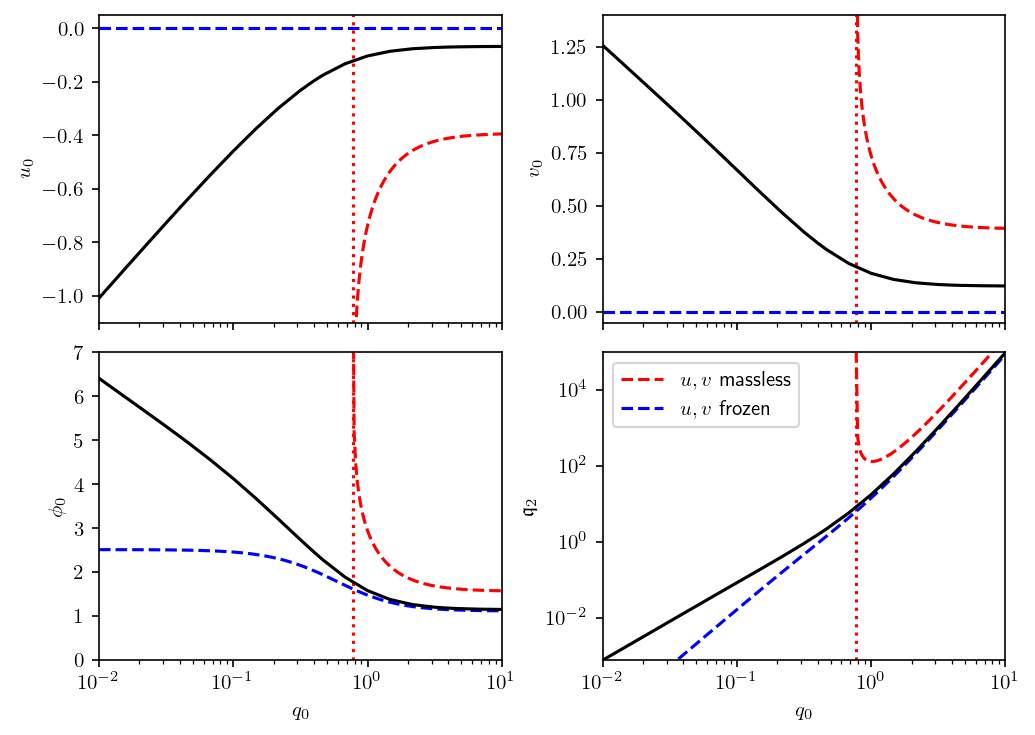

In [25]:
mask = np.where(χinfs == 0)[0]
mask = mask[np.argsort(q0s[mask])]

q0s_ml = np.geomspace(0.7728, max(q0s[mask]), 100)
data_ml = np.asarray([wh.massless_approx_T11(q0) for q0 in q0s_ml])
u0_ml, v0_ml, φ0_ml, charge2_ml = data_ml.T

q0s_fr = np.geomspace(min(q0s[mask]), max(q0s[mask]), 100)
data_fr = np.asarray([wh.frozen_approx_T11(q0) for q0 in q0s_fr])
u0_fr, v0_fr, φ0_fr, charge2_fr = data_fr.T


fig, axes = plt.subplots(2, 2, figsize=(7,5), sharex=True)

axes[0,0].plot(q0s_ml, u0_ml, '--r')
axes[0,0].plot(q0s_fr, u0_fr, '--b')
axes[0,0].plot(q0s[mask], u0s[mask], 'k')

axes[0,1].plot(q0s_ml, v0_ml, '--r')
axes[0,1].plot(q0s_fr, v0_fr, '--b')
axes[0,1].plot(q0s[mask], v0s[mask], 'k')

axes[1,0].plot(q0s_ml, φ0_ml, '--r')
axes[1,0].plot(q0s_fr, φ0_fr, '--b')
axes[1,0].plot(q0s[mask], φ0s[mask], 'k')

axes[1,1].plot(q0s_ml, charge2_ml, '--r', label='$u,v$ massless')
axes[1,1].plot(q0s_fr, charge2_fr, '--b', label='$u,v$ frozen')
axes[1,1].plot(q0s[mask], charge2s[mask], 'k')

for ax, ylab in zip(axes.ravel(), ['$u_0$', '$v_0$', '$\phi_0$', '$\mathfrak{q}_2$']):
    ax.axvline(q0s_ml[0], ls=':', c='r', zorder=0)
    ax.set_ylabel(ylab)

plt.xlim(min(q0s[mask]), max(q0s[mask]))
plt.xscale('log')
axes[1,0].set_xlabel('$q_0$')
axes[1,1].set_xlabel('$q_0$')

axes[0,0].set_ylim(-1.1, 0.05)
axes[0,1].set_ylim(-0.05, 1.4)
axes[1,0].set_ylim(0, 7)
axes[1,1].set_ylim(min(charge2s[mask]), max(charge2s[mask]))
axes[1,1].set_yscale('log')

axes[1,1].legend()

plt.tight_layout()
plt.subplots_adjust(wspace=0.25)
# plt.savefig('images/T11_ranges_chi=0.png', dpi=300)
plt.show()

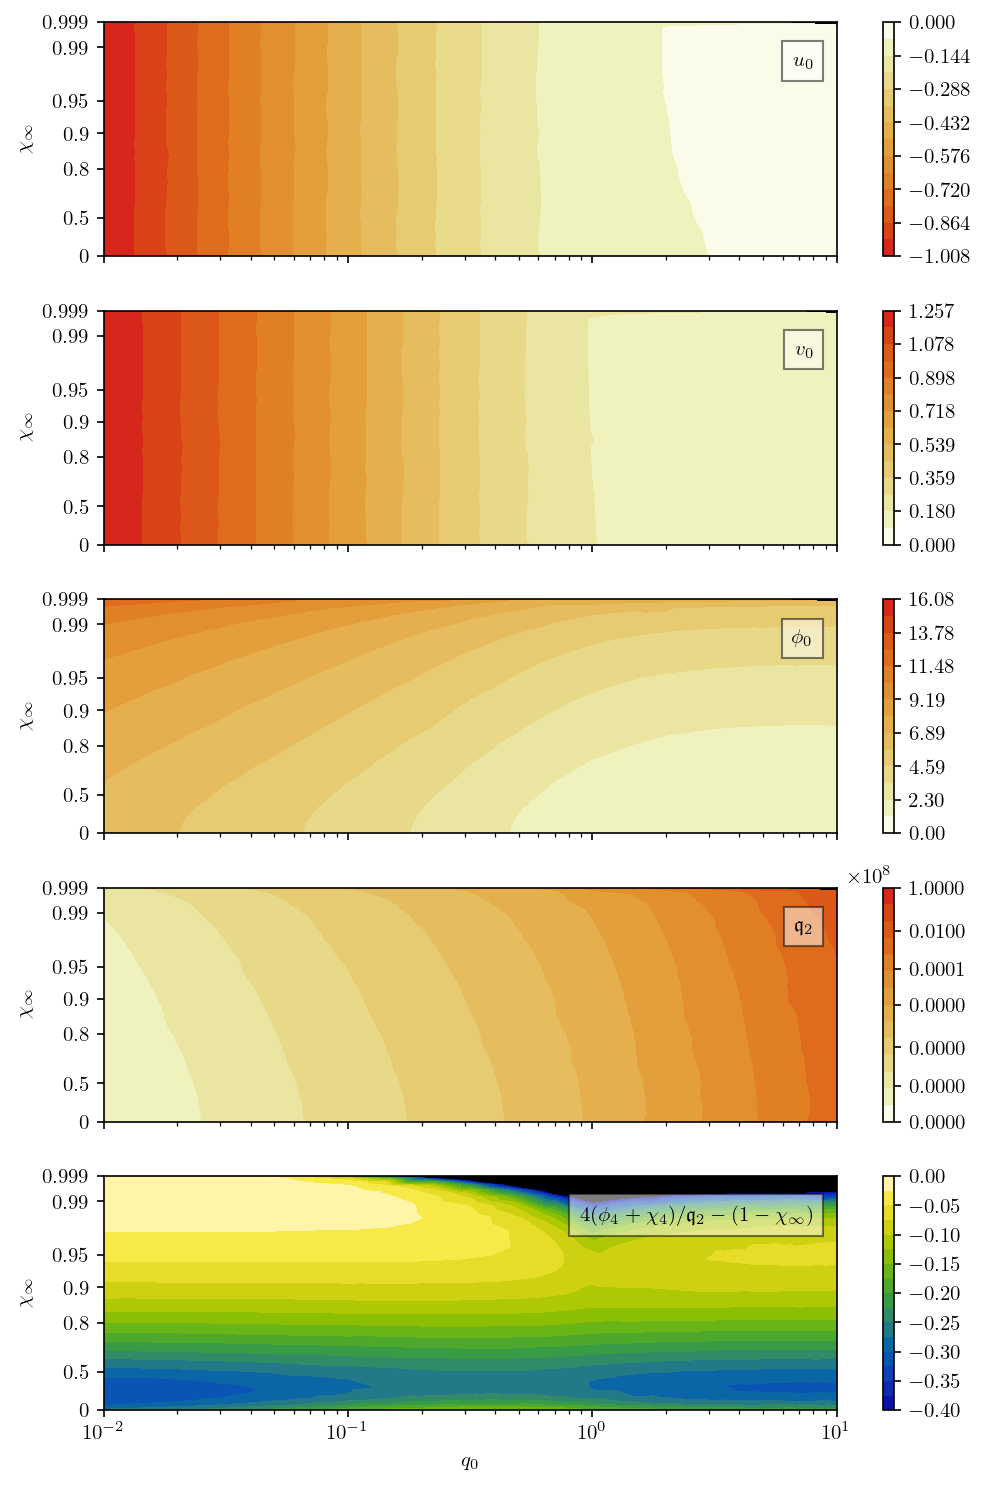

In [24]:
x0 = 1.015
def myTransform(x):
    return -x0*np.log(1-x/x0)
def myTransform_inverse(x):
    return x0*(1 - np.exp(-x/x0))

# Perform triangulation on log data
tri = Triangulation(np.log(q0s), myTransform(χinfs))
tri.x = np.exp(tri.x)
tri.y = myTransform_inverse(tri.y)


fig, axes = plt.subplots(5, 1, figsize=(7,10), sharex=True, sharey=True)

for ax in axes:
    ax.set_facecolor('black')

levels_bps = np.arange(0, -0.41, -0.025)[::-1]


im = axes[0].tricontourf(tri, u0s, levels=np.linspace(min(u0s), 0, 15), cmap=cc.cm['CET_L18_r'])
plt.colorbar(im, ax=axes[0])

im = axes[1].tricontourf(tri, v0s, levels=np.linspace(0, max(v0s), 15), cmap=cc.cm['CET_L18'])
plt.colorbar(im, ax=axes[1])

im = axes[2].tricontourf(tri, φ0s, levels=np.linspace(0, max(φ0s), 15), cmap=cc.cm['CET_L18'])
plt.colorbar(im, ax=axes[2])

im = axes[3].tricontourf(tri, charge2s, levels=np.geomspace(10**-4, 10**8, 15),
                         cmap=cc.cm['CET_L18'], norm=colors.LogNorm())
plt.colorbar(im, ax=axes[3], ticks=np.geomspace(10**-4, 10**8, 7))

im = axes[4].tricontourf(tri, bps, levels=levels_bps, cmap=cc.cm['CET_L9'])
plt.colorbar(im, ax=axes[4])
# plt.scatter(q0s, χinfs, color='r', s=1)

labels = ['$u_0$', '$v_0$', '$\phi_0$', '$\mathfrak{q}_2$', '$4(\phi_4+\chi_4)/\mathfrak{q}_2 - (1-\chi_\infty)$']
for ax, label in zip(axes, labels):
    ax.set_ylabel('$\chi_\infty$')
    ax.text(8, 0.98, label, ha='right',
            bbox={'boxstyle': 'square', 'alpha': 0.5, 'facecolor': 'w', 'edgecolor': 'k', 'pad': 0.5})
    # ax.scatter(q0s, χinfs, color='b', s=1)


plt.xscale('log')
plt.xlabel('$q_0$')


plt.yscale('function', functions=(myTransform, myTransform_inverse))
plt.ylim(0, 0.999)
yticks = [0, 0.5, 0.8, 0.9, 0.95, 0.99, 0.999]
plt.yticks(yticks, labels=['${}$'.format(yt) for yt in yticks])


plt.tight_layout()
# plt.subplots_adjust(left=0, right=1, bottom=0, top=1)
# plt.savefig('images/T11_params_BPS.png', dpi=300)
plt.show()

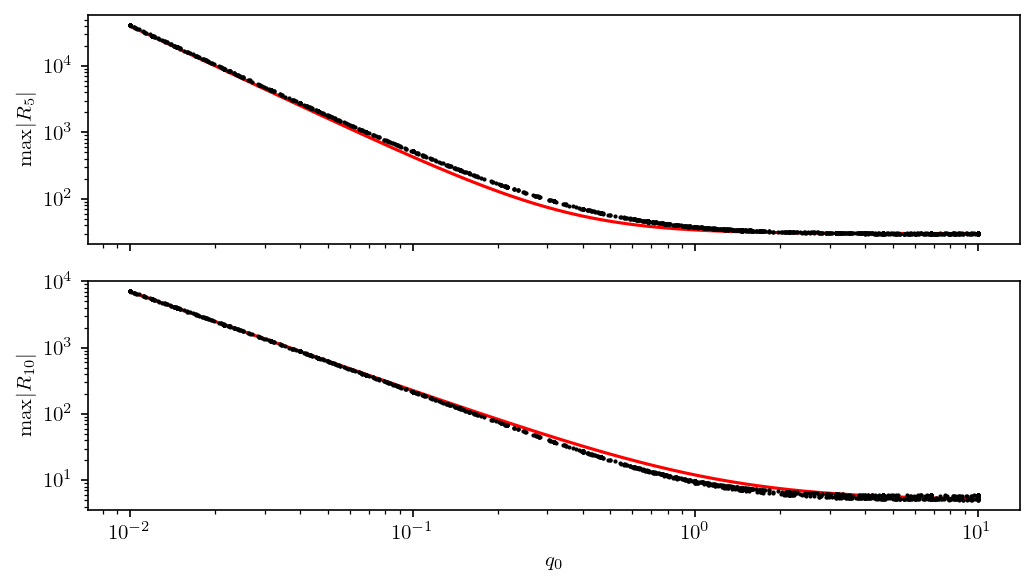

In [128]:
fig, axes = plt.subplots(2, 1, figsize=(7,4), sharex=True)

xx = np.geomspace(0.01, 10, 1000)
axes[0].plot(xx, 4/xx**2 + 30, 'r')
axes[1].plot(xx, 7/xx**1.5 + 5, 'r')

axes[0].scatter(q0s, -ric5s, c='k', s=1, zorder=2)
axes[1].scatter(q0s, -ric10s, c='k', s=1, zorder=2)

plt.xscale('log')
plt.xlabel('$q_0$')

axes[0].set_yscale('log')
axes[1].set_yscale('log')
axes[0].set_ylabel('$\mathrm{max}|R_5|$')
axes[1].set_ylabel('$\mathrm{max}|R_{10}|$')

plt.tight_layout()
plt.show()